In [1]:
import os
import librosa
import torch
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split

# Path to your dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  # 1 second audio clips
N_MELS = 128
N_FFT = 400

def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))  # Pad/Trim
    return audio

def extract_features(file_path):
    """Extract mel spectrogram features"""
    audio = load_audio(file_path)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Load all audio files and extract features
def create_dataset(data_path):
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)

            # Check for audio files only
            if file_path.endswith(('.wav', '.mp3', '.flac')):  
                features = extract_features(file_path)
                X.append(features)
                y.append(label_map[label])
    return np.array(X), np.array(y), label_map

X, y, label_map = create_dataset(DATA_PATH)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch Datasets
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio

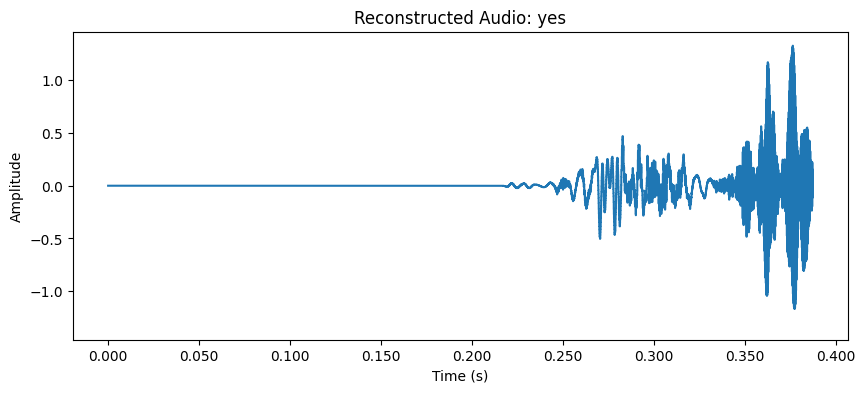

In [25]:
label_map = {0: 'bed', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'down', 5: 'eight',
             6: 'five', 7: 'four', 8: 'go', 9: 'happy', 10: 'house', 11: 'left',
             12: 'marvin', 13: 'nine', 14: 'no', 15: 'off', 16: 'on', 17: 'one',
             18: 'right', 19: 'seven', 20: 'sheila', 21: 'six', 22: 'stop',
             23: 'three', 24: 'tree', 25: 'two', 26: 'up', 27: 'wow', 28: 'yes', 29: 'zero'}
HOP_LENGTH = N_FFT // 2 
# Loop through the batches
for batch in train_loader:
    audio, labels = batch
    
    # Extract the first sample
    mel_spectrogram = audio[0].numpy()  # Convert tensor to numpy
    label_idx = labels[0].item()  # Get the label index
    class_name = label_map[label_idx]  # Map to class name

    # Convert from dB to power spectrogram
    mel_power = librosa.db_to_power(mel_spectrogram)

    # Invert mel spectrogram to linear spectrogram
    mel_to_linear = librosa.feature.inverse.mel_to_stft(
        mel_power, sr=SAMPLE_RATE, n_fft=N_FFT, power=1.0
    )

    # Use Griffin-Lim to reconstruct waveform
    waveform = librosa.griffinlim(mel_to_linear, hop_length=HOP_LENGTH, win_length=N_FFT)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
    plt.title(f"Reconstructed Audio: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # 🎧 Play the reconstructed audio
    display(Audio(waveform, rate=SAMPLE_RATE))

    break  # Exit after processing the first batch

In [11]:
print(X.shape[2])

32


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

class PositionalEncoding(nn.Module):
    """Positional encoding to add temporal information to the transformer"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=4, hidden_dim=256):
        super(TransformerModel, self).__init__()
        
        self.positional_encoding = PositionalEncoding(input_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.3,
            activation='gelu',
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Positional encoding
        x = self.positional_encoding(x)
        
        # Transformer layers
        x = self.transformer(x)
        
        # Pooling over the time dimension
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
input_dim = X.shape[2]  # N_MELS
model = TransformerModel(input_dim, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 10
train(model, train_loader, criterion, optimizer, device, num_epochs)


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 10
train(model, train_loader, criterion, optimizer, device, num_epochs)


Epoch 1/10: 100%|██████████| 1618/1618 [00:19<00:00, 82.24it/s, accuracy=80.5, loss=0.412]


Epoch 1: Loss = 0.6059, Accuracy = 80.49%


Epoch 2/10: 100%|██████████| 1618/1618 [00:19<00:00, 83.00it/s, accuracy=80.8, loss=0.542]


Epoch 2: Loss = 0.6040, Accuracy = 80.76%


Epoch 3/10: 100%|██████████| 1618/1618 [00:19<00:00, 82.53it/s, accuracy=80.6, loss=0.535]


Epoch 3: Loss = 0.6075, Accuracy = 80.61%


Epoch 4/10: 100%|██████████| 1618/1618 [00:19<00:00, 83.52it/s, accuracy=80.7, loss=0.64] 


Epoch 4: Loss = 0.6064, Accuracy = 80.65%


Epoch 5/10: 100%|██████████| 1618/1618 [00:19<00:00, 82.67it/s, accuracy=81, loss=0.291]  


Epoch 5: Loss = 0.5965, Accuracy = 80.99%


Epoch 6/10: 100%|██████████| 1618/1618 [00:19<00:00, 82.49it/s, accuracy=80.7, loss=0.547]


Epoch 6: Loss = 0.6032, Accuracy = 80.74%


Epoch 7/10: 100%|██████████| 1618/1618 [00:19<00:00, 82.87it/s, accuracy=80.9, loss=0.803]


Epoch 7: Loss = 0.5962, Accuracy = 80.92%


Epoch 8/10: 100%|██████████| 1618/1618 [00:19<00:00, 82.92it/s, accuracy=80.8, loss=0.742]


Epoch 8: Loss = 0.5960, Accuracy = 80.77%


Epoch 9/10: 100%|██████████| 1618/1618 [00:19<00:00, 83.18it/s, accuracy=81, loss=0.842]   


Epoch 9: Loss = 0.5923, Accuracy = 81.01%


Epoch 10/10: 100%|██████████| 1618/1618 [00:19<00:00, 83.03it/s, accuracy=81, loss=0.602]  

Epoch 10: Loss = 0.5927, Accuracy = 81.03%


In [39]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(data_loader, desc="Evaluating", leave=True)

    for batch in loop:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Transpose inputs for transformer
        #inputs = inputs.transpose(1, 2)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    

In [41]:
evaluate(model, test_loader, criterion, device)


Evaluating: 100%|██████████| 405/405 [00:02<00:00, 182.05it/s, accuracy=75, loss=1.14]   

Validation Loss: 1.3057, Accuracy: 74.96%


In [42]:
def test_single_sample(model, test_loader, label_map, device):
    """Test the model on a single sample from the test loader"""
    model.eval()

    # Get one batch from the test loader
    batch = next(iter(test_loader))
    inputs, labels = batch

    # Select the first sample
    input_sample = inputs[0].unsqueeze(0).to(device)  # Add batch dimension
    label_idx = labels[0].item()
    actual_class = label_map[label_idx]

    # Transpose input for the transformer (batch_size, seq_len, input_dim)
    #input_sample = input_sample.transpose(1, 2)

    # Model inference
    with torch.no_grad():
        output = model(input_sample)
        _, pred_idx = torch.max(output, 1)
        predicted_class = label_map[pred_idx.item()]

    # Display prediction result
    print(f"🎯 Actual: {actual_class}")
    print(f"🔮 Predicted: {predicted_class}")

   

# 🎯 Execute the test with a single sample
test_single_sample(model, test_loader, label_map, device)

🎯 Actual: three
🔮 Predicted: three


In [84]:
import torch

def test_all_samples(model, test_loader, label_map, device):
    """Test the model on all samples from the test loader"""
    model.eval()

    total = 0
    correct = 0

    print("\n📊 **Model Predictions on Test Set:**\n")

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Transpose input if required by the model
            #inputs = inputs.transpose(1, 2)  # (batch_size, seq_len, input_dim)

            # Model inference
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Print actual and predicted classes for each sample
            for i in range(len(labels)):
                actual_class = label_map[labels[i].item()]
                predicted_class = label_map[preds[i].item()]
                print(f"✅ Actual: {actual_class}  |  🔮 Predicted: {predicted_class}")

                if actual_class == predicted_class:
                    correct += 1
                total += 1

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    print(f"\n🎯 Overall Accuracy: {accuracy:.2f}% on {total} samples")

# 🎯 Execute the test across the entire test set
test_all_samples(model, test_loader, label_map, device)



📊 **Model Predictions on Test Set:**

✅ Actual: three  |  🔮 Predicted: three
✅ Actual: bed  |  🔮 Predicted: cat
✅ Actual: one  |  🔮 Predicted: one
✅ Actual: bed  |  🔮 Predicted: go
✅ Actual: off  |  🔮 Predicted: off
✅ Actual: on  |  🔮 Predicted: on
✅ Actual: down  |  🔮 Predicted: down
✅ Actual: yes  |  🔮 Predicted: yes
✅ Actual: bed  |  🔮 Predicted: bed
✅ Actual: three  |  🔮 Predicted: two
✅ Actual: up  |  🔮 Predicted: up
✅ Actual: sheila  |  🔮 Predicted: sheila
✅ Actual: no  |  🔮 Predicted: one
✅ Actual: sheila  |  🔮 Predicted: sheila
✅ Actual: nine  |  🔮 Predicted: nine
✅ Actual: three  |  🔮 Predicted: tree
✅ Actual: on  |  🔮 Predicted: five
✅ Actual: wow  |  🔮 Predicted: wow
✅ Actual: zero  |  🔮 Predicted: zero
✅ Actual: five  |  🔮 Predicted: five
✅ Actual: bird  |  🔮 Predicted: bird
✅ Actual: three  |  🔮 Predicted: three
✅ Actual: on  |  🔮 Predicted: on
✅ Actual: tree  |  🔮 Predicted: tree
✅ Actual: dog  |  🔮 Predicted: wow
✅ Actual: down  |  🔮 Predicted: down
✅ Actual: go  |  🔮 P